# Clustering Techniques

Se aplicarán técnicas de agrupación como *k-means* al set de datos proporcionado y se determinará si los datos del conjunto pueden ser agrupados y cuáles son los grupos óptimos.

### Tabla de contenidos

- [Carga del dataset](#Carga-del-dataset)
- [Análisis descriptivo de los datos](#Análisis-descriptivo-de-los-datos)
- [Tratamiento de datos](#Tratamiento-de-datos)
  - [Missing Values](#Missing-Values)
  - [Normalización](#Normalización)
- [Conjuntos de entrenamiento y validación](#Conjuntos-de-entrenamiento-y-validación)
- [Agrupamiento *k-medias*](#Agrupamiento-k-medias)
- [Análisis de los resultados](#Análisis-de-los-resultados)
  - [Estudio de centros geométricos de los clusters resultantes](#Estudio-de-centros-geométricos-de-los-clusters-resultantes)
  - [Representación visual de resultados](#Representación-visual-de-resultados)
- [Conclusiones](#Conclusiones)
- [Apéndice](#Apéndice)
  - [Clustering Jerárquico](#Clustering-Jerárquico)

In [1]:
### Imports y funciones auxiliares

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import errno
import math
import os
import sys

# Función para validar que el fichero existe
def assert_fichero(nombre):
    if (not os.path.isfile(nombre)):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), nombre)
        
# Función para imprimir mensajes por la salida de error
def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)
    
# Función para representar histograma por grupos con las categorías agregadas
def histogramas_con_categorias_agregadas(df_agrupado, nombre_algoritmo, nombre_archivo=None):
    
    # Preparación de los datos para representación
    ## Se eliminan las columnas de Channel y Region y se agrupan los registros por Group
    df_agregado = df_agrupado.drop(['Channel', 'Region'], axis=1).groupby('Group')
    
    ## Se obtienen los números de muestras por grupo
    n_muestras_grupo = df_agregado['Group'].count()
    
    ## Se suman todos los registros y se dividen por el número de muestras de cada grupo
    df_agregado = df_agregado.sum().divide(n_muestras_grupo, axis='index').T
    
    n_grupos = len(df_agregado.columns)
    n_categorias = len(df_agregado.index)
    
    grupos = np.arange(n_grupos)
    offset_y = np.zeros(n_grupos)
    
    # Elementos de estilo
    ancho_barras = 0.6
    colors = ['xkcd:goldenrod', 'xkcd:coral', 'xkcd:turquoise',
              'xkcd:sea blue', 'xkcd:lavender', 'xkcd:indigo']

    f = plt.figure()
    for categoria in np.arange(0, n_categorias):
        plt.bar(grupos, df_agregado.iloc[categoria], ancho_barras, 
                bottom=offset_y, color=colors[categoria])
        
        offset_y += df_agregado.iloc[categoria]
    
    _ = plt.ylabel('Gastos totales normalizados por categoría\ny número de muestras en grupo')
    _ = plt.xlabel('Grupos')
    _ = plt.title('Agrupación con {:s}'.format(nombre_algoritmo))
    _ = plt.xticks(grupos, ['G{:d}'.format(x) for x in grupos])
    _ = plt.legend(df_agregado.index, title='Categorías',
                   loc='center left', bbox_to_anchor=(1, 0.5))
    
    if nombre_archivo:
        f.savefig("{:s}.pdf".format(nombre_archivo), bbox_inches='tight')
        
    plt.show()

### Carga del dataset

El conjunto de datos proporcinado se encuentra disponible en el fichero `Wholesale customers data.csv` que ha sido descargado desde la web: [Machine Learning Repository - Wholesale customers Data Set](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)

```sh
curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv
```

En el enlace anterior puede encontrarse más información acerca del contenido del fichero.

In [2]:
# Descomentar la siguiente línea para descargar el dataset
#!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv

# Comprobación de que el fichero de datos está disponible
fichero_datos = 'Wholesale customers data.csv'
assert_fichero(fichero_datos)

# Carga del archivo como un DataFrame de Pantas con separador de columnas ','
df_raw = pd.read_csv(fichero_datos, sep=',')

# Muestra una descripción estadística del conjunto de datos
df_raw.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Análisis descriptivo de los datos

En base a la información disponible en la [web anterior](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers), se conoce que las variables `Fresh`, `Milk`, `Grocery`, `Frozen`, `Detergents_Paper` y `Delicassen` son variables continuas que reflejan el gasto anual en cada uno de los productos asociados.

Mientras que `Channel` y `Region` hacen referencia a variables categóricas:

- `Channel` puede tomar los valores `Horeca` (*Hotel/Restaurante/Cafeteria*) (`298` registros) o `Retail` (`142` registros).
- `Region` puede tomar los valores `Lisboa` (`77` registros), `Oporto` (`47` registros) y `Resto de regiones` (`316` registros).

Aunque en la información aportada en la web no se da una relación directa entre las categorías y los valores numéricos asociados, sí se da información acerca del número de entradas disponibles en el conjunto de datos para cada una de estas categorías.

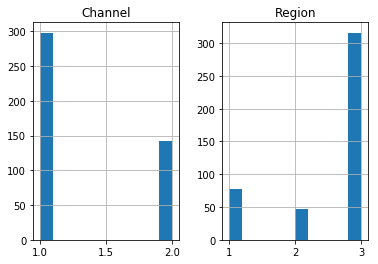

In [3]:
_ = df_raw[['Channel', 'Region']].hist()

De los histogramas puede extraerse la información necesaria para relacionar el valor numérico que se ha asociado a cada una de las categorías con su valor real.

Así pues:

- **Channel**
  - *Horeca* = `1`
  - *Retail* = `2`

- **Region**
  - *Lisboa* = `1`
  - *Oporto* = `2`
  - *Otras regiones* = `3`

### Tratamiento de datos

Antes de generar los clusters en base a los datos aportados, es necesario hacer un pre-tratamiento de estos para que el algoritmo de clustering pueda trabajar correctamente con ellos.

#### Missing Values

En este caso, puede verse que el conjunto de datos no dispone de ningún registro incompleto, por lo que no debe hacerse ningún tratamiento al respecto.

In [4]:
# Se buscan los registros que tengan algún elemento nulo
numero_registros_con_elementos_nulos = df_raw[df_raw.isnull().any(axis=1)].shape[0]

if numero_registros_con_elementos_nulos > 0:
    eprint("Se han encotrado registros que tienen algún elemento nulo. Hay que tratar el dataset antes de continuar")
else:
    print("No se han encontrado registros que tengan elementos nulos. No hay que hacer limpieza del dataset.")

No se han encontrado registros que tengan elementos nulos. No hay que hacer limpieza del dataset.


#### Normalización

Para que los algoritmos de clustering puedan agrupar los registros deben poder calcular correctamente las distancias entre los mismos, y para que todas las variables aporten el mismo peso las distancias deben ser del mismo orden, lo que implica que los datos deben estar normalizados.

En este caso se hará uso de la clase [`sklearn.preprocessing.MaxAbsScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) que normaliza cada variable dividiendo todos sus registros por el máximo absoluto de la misma.

In [5]:
from sklearn.preprocessing import MaxAbsScaler

transformer = MaxAbsScaler()
df = pd.DataFrame(transformer.fit_transform(df_raw), columns=df_raw.columns)

df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.661364,0.847727,0.107001,0.078863,0.085700,0.050468,0.070578,0.031806
std,0.234026,0.258091,0.112771,0.100416,0.102427,0.079756,0.116782,0.058822
min,0.500000,0.333333,0.000027,0.000748,0.000032,0.000411,0.000073,0.000063
25%,0.500000,0.666667,0.027889,0.020858,0.023205,0.012194,0.006289,0.008515
50%,0.500000,1.000000,0.075826,0.049348,0.051256,0.025070,0.019999,0.020138
75%,1.000000,1.000000,0.150991,0.097829,0.114850,0.058392,0.096064,0.037967
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Conjuntos de entrenamiento y validación

En el caso de los algoritmos de agrupación no supervisados, al no disponerse de una variable objetivo, no tiene sentido hablar de conjuntos de entrenamiento y validación dado que no hay una respuesta correcta contra la que poder comparar el algoritmo entrenado.

Por tanto, se proveerá con el `100%` de los datos al algoritmo de clustering para que realice el agrupamiento con todos ellos.

### Agrupamiento *k-medias*

Para realizar el *clustering* de los datos se usará la clase [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Este algoritmo requiere únicamente el número de agrupaciones que se quieren obtener o parámetro `k`, pero como no se dispone de ninguna restricción sobre este parámetro de entrada, se hará uso de la función [`sklearn.metrics.silhouette_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) para calcular como métrica la media del coeficiente de silueta de los clusters generados que se calcula con la media de las distancias de los puntos del cluster y la distancia media al cluster más cercano de cada una de las muestras del cluster.

Los valores obtenidos para esta métrica se encuentran dentro del rango `[-1, 1]`.

- Generalmente, valores negativos indican que se han asignado erróneamente muestras a un cluster dado.
- `0` indica que hay solape entre clusters.
- `1` es el mejor valor que se puede obtener.

En este caso, se probarán distintos valores de `k`, comprendidos entre `2` y `10` para determinar con la métrica anterior cuál es la mejor agrupación posible para el set de datos tratado.

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_model = None
best_labels = None
best_k = None
best_silhouette_avg = None

for n_clusters in range(2, 11):
    model = KMeans(n_clusters=n_clusters,
                   random_state=10, # Se fija la semilla para facilitar la reproducibilidad de los resultados
                   n_jobs=-1        # Se establece a -1 el número de trabajos para usar todos los hilos de ejecución
                  )
    
    cluster_labels = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    if not best_silhouette_avg or best_silhouette_avg < silhouette_avg:
        best_silhouette_avg = silhouette_avg
        best_model = model
        best_labels = cluster_labels
        best_k = len(np.unique(best_labels))

df_agrupado = pd.concat([df, pd.Series(best_labels, name='Group')],
                        axis=1, sort=False)
        
print("Mejor configuración de agrupación obtenida:")
print("  - k = {:d}".format(best_k))
print("  - Media de silhouette_score: {:.2f}".format(best_silhouette_avg))

Mejor configuración de agrupación obtenida:
  - k = 5
  - Media de silhouette_score: 0.59


### Análisis de los resultados

Dado que el conjunto de datos dispone de más de dos (y de tres) variables para la agrupación, la representación visual de los *clusters* resultantes no es directa.

Por lo que las conclusiones sobre las agrupaciones deberán extraerse a partir de los centros de los *clusters* obtenidos y de representar gráficamente la información agrupada pero separadamente.

#### Estudio de centros geométricos de los clusters resultantes

Para que el estudio de los centros geométricos de los clusters sea más intuitivo, se aplicarán las transformaciones inversas a la normalización empleada en [*Tratamiento de datos - Normalización*](#Normalización).

In [7]:
df_centros = pd.DataFrame(transformer.inverse_transform(best_model.cluster_centers_),
                          columns=df.columns)

df_centros['Group'] = pd.Series(range(0,5))
df_centros['Count'] = df_agrupado.groupby('Group')['Group'].count()
df_centros.set_index('Group', inplace=True)

df_centros.style.highlight_max(color='turquoise').highlight_min(color='coral')

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Count
Group,,,,,,,,,
0,1,3,13878.1,3486.98,3886.73,3656.9,786.682,1518.28,211
1,1,1.32184,12499.4,3366.22,4145.01,3969.8,799.966,1167.78,87
2,2,1.5,6209.47,10104.4,15983.3,2101.5,7493,1556.14,36
3,2,3,9178.34,8799.59,13575.1,1428.09,5630.35,1750.31,98
4,2,2.875,17674.5,36953.2,51511.1,2383,26343.5,2679.62,8


A partir de la tabla pueden sacarse las siguientes conclusiones:

- A partir de los máximos (*turquesa*) puede deducirse que el grupo `4` es el más adinerado, dado que es el grupo que de media más gasta y además es un grupo bastante reducido, apenas 8 muestras de las 440.
- A partir de los mínimos (*coral*) no queda claro si el grupo `0` o el `1` son los menos pudientes. Ambos grupos tienen gastos similares, sin embargo, el grupo `0` está deslocalizado geográficamente dado que pertenece a la región 3 mientras que el grupo `1` se podría decir que está principalmente localizado en *Lisboa* dado que la región asignada al centro está próxima a 1. No obstante, el hecho de el grupo `1` tenga un máximo en cuanto al gasto en congelados, puede dar a entender que tiene mayor poder adquisitivo frente al grupo `0`.
- Las diferencias entre los grupos `2` y `3` parecen ser más bien puramente geográficas dado que a nivel de gastos ambos grupos son similares.

#### Representación visual de resultados

Como ya se ha mencionado, la representación visual de los datos cuando se trata de más de 3 variables involucradas en el estudio se complica, dado que no se dispone de una representación espacial intuitiva.

Para intentar corroborar los resultados extráidos a partir del estudio de los centros geométricos de los clusters, se ha representado individualmente cada variable separando cada uno de los grupos.

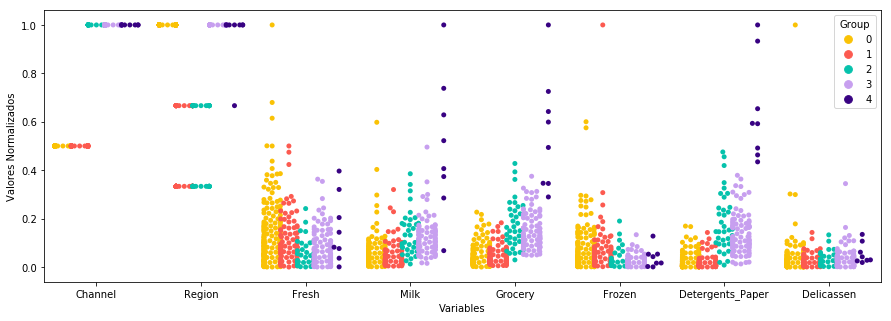

In [8]:
fig = plt.figure(figsize=(15, 5))

etiqueta_x = "Variables"
etiqueta_y = "Valores Normalizados"
agrupar_por = "Group"

df_representar = pd.melt(df_agrupado, agrupar_por,
                         var_name=etiqueta_x, value_name=etiqueta_y)

paleta_colores = sns.xkcd_palette(colors=['goldenrod', 'coral',
                                          'turquoise', 'lavender', 'indigo'])

fig = sns.swarmplot(data=df_representar, x=etiqueta_x, y=etiqueta_y,
                    hue=agrupar_por, palette=paleta_colores, dodge=True)

La primera conclusión que se puede extraer de la gráfica es que el grupo `0` es el que más población tiene; seguido de los grupos `1` y `3`; después por el grupo `2` y finalmente el grupo `4`.

En la gráfica también llama la atención que el grupo `4` tiene las muestras de mayor gasto en *Milk*, *Grocery* y *Detergents & Paper*.

Otro punto a tener en cuenta es que la variable *Channel* tiene mucho peso a la hora de generar los *clusters* dado que todas las muestras de un mismo cluster pertenecen al mismo *Channel*. No así en el caso de la variable *Region* donde hay clusters con muestras en dos categorías distintas como los grupos `1` y `2` y en menor medida el grupo `4`.

Un posible dato interesante es que, descontando el grupo `4` por la baja cantidad de muestras, el grupo `2` es el grupo con mayor dispersión en las muestras lo que puede indicar que se trata de un grupo con mayor inhomogeneidad que el resto.

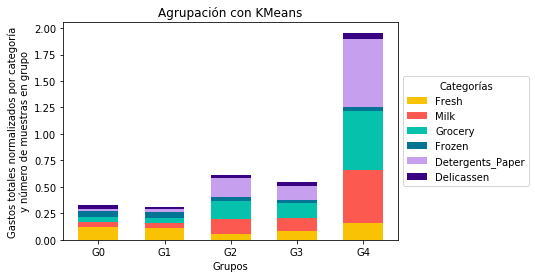

In [9]:
histogramas_con_categorias_agregadas(df_agrupado, nombre_algoritmo='KMeans')

Otra manera de representar gráficamente los resultados es la gráfica superior, que muestra los gastos totales normalizados y segementados por categoría de cada grupo y dividos por el número de muestras de cada grupo.

Al estar divididos los datos totales por el número de muestras de cada grupo pueden compararse y ver en proporción qué grupo gasta más en cada una de las categorías.

Como ya se había visto a los largo del análisis de los resultados, el grupo `4` es el grupo que más gasta mientras que los grupos `0` y `1` los que menos.

Además es interesante ver cómo los grupos `0` y `1` son muy parecidos entre ellos, al igual que los grupos `2` y `3`, lo que podría llevar a pensar que los dos primeros grupos podrían haber sido uno solo y los otros dos otro único grupo. Incluso podría llegar a pensarse que los 4 grupos podrían ser uno.

Sin embargo, he aquí la *trampa*, en esta gráfica no se representan las variables *Channel* y *Region*  que si se analizan en la tabla para los grupos citados, puede comprobarse que efectivamente estas variables hacen que los grupos sean distintos.

Los grupos `0` y `1` comparten igual *Channel* pero tienen distinto valor de *Region*. La situación es análoga para los grupos `2` y `3`. Además el valor de *Channel* entre los dos primeros grupos y los dos segundos tampoco coincide.

### Conclusiones

El método *K-Medias* ha sido capaz de agrupar un conjunto de datos de 8 variables, y además se ha podido hacer uso de una métrica que ayudase a determinar cuál era el mejor número de clusters.

Un punto negativo del estudio es que debido a la gran cantidad de variables, su representación visual no es sencilla ni intuitiva lo que complica poder obtener conclusiones acerca de los *clusters* generados a partir de una representación gráfica de los datos.

En este caso, los centros geométricos de los datos ha sido la fuente de información que más ha ayudado a extraer conclusiones sobre los grupos obtenidos.

Aunque de nuevo este segundo método se complica si el número de variables es demasiado grande.

Esto demuestra que aunque los métodos de agrupación son eficaces y sencillos de utilizar, extraer conclusiones a partir de los resultados no es trivial.

### Apéndice

#### Clustering Jerárquico

Por completitud y para tener otro método de agrupamiento con el que poder comparar los resultados, se ha probado también la clase [`sklearn.cluster.AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) que implementa un algoritmo de *agrupamiento jerárquico*, comenzando con *n-grupos* y agrupándolos de dos en dos hasta que sólo quede uno.

Igual que en el [agrupamiento k-medias](#Agrupamiento-k-medias), se ha usado la métrica `silhoutte_score` con el fin de determinar el número de clusters óptimo.

In [10]:
from sklearn.cluster import AgglomerativeClustering

best_model_h = None
best_labels_h = None
best_n_clusters_h = None
best_silhouette_avg_h = None

for n_clusters in range(2, 11):
    model = AgglomerativeClustering(n_clusters=n_clusters)

    cluster_labels = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    if not best_silhouette_avg_h or best_silhouette_avg_h < silhouette_avg:
        best_silhouette_avg_h = silhouette_avg
        best_model_h = model
        best_labels_h = cluster_labels
        best_n_clusters_h = len(np.unique(best_labels_h))

df_agrupado_h = pd.concat([df, pd.Series(best_labels_h, name='Group')],
                          axis=1, sort=False)
        
print("Mejor configuración de agrupación obtenida:")
print("  - Número de clusters: {:d}".format(best_n_clusters_h))
print("  - Media de silhouette_score: {:.2f}".format(best_silhouette_avg_h))

Mejor configuración de agrupación obtenida:
  - Número de clusters: 5
  - Media de silhouette_score: 0.59


In [11]:
### Cálculo de los 'centros' de los clusters jerárquicos
df_centros_h__ = pd.concat([df_raw, pd.Series(best_labels_h, name='Group')],
                            axis=1, sort=False)

df_centros_h = df_centros_h__.groupby('Group').mean()
df_centros_h['Count'] = df_centros_h__.groupby('Group')['Group'].count()

df_centros_h.style.highlight_max(color='turquoise').highlight_min(color='coral')

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Count
Group,,,,,,,,,
0,1,2.99528,13966.9,3549.7,3932.67,3926.77,788.972,1537.58,212
1,2,3,9038.2,9313.69,14208.8,1443.93,6065.85,1776.47,101
2,1,1.31395,12264.3,3210.2,4034.77,3308.19,794.477,1116.14,86
3,2,1.5,6209.47,10104.4,15983.2,2101.5,7493,1556.14,36
4,2,2.8,25603,43460.6,61472.2,2636,29974.2,2708.8,5


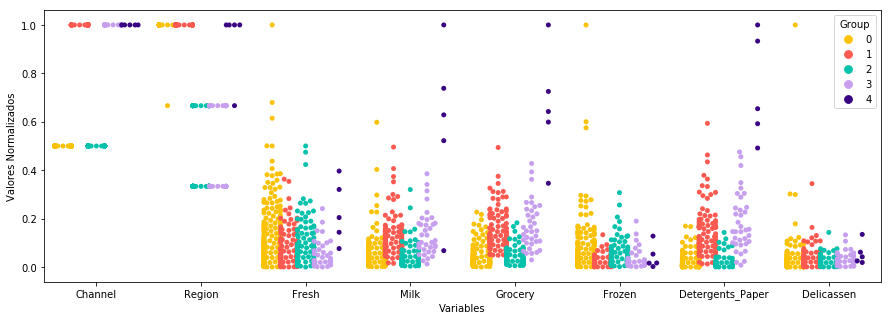

In [12]:
### Representación visual de los grupos por agrupamiento jerárquico
fig = plt.figure(figsize=(15, 5))

df_representar_h = pd.melt(df_agrupado_h, agrupar_por,
                           var_name=etiqueta_x, value_name=etiqueta_y)

fig = sns.swarmplot(data=df_representar_h, x=etiqueta_x, y=etiqueta_y,
                    hue=agrupar_por, palette=paleta_colores, dodge=True)

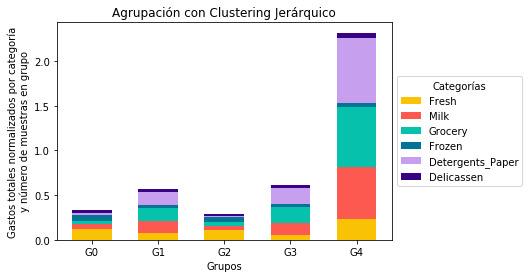

In [13]:
### Representación de los grupos por gastos totales por númeor de muestras en grupo
histogramas_con_categorias_agregadas(df_agrupado_h, nombre_algoritmo='Clustering Jerárquico')

En este caso el número de grupos óptimo también ha resultado ser `5` y aunque la numeración difiere con respecto a los grupos obtenidos en el caso de *k-medias* los grupos son muy parecidos, salvo por alguna fluctuación de muestras.

Sin embargo, pese a que los resultados no difieren mucho entre uno y otro método de agrupamiento, sí pueden apreciarse diferencias sutiles. Por ejemplo, ahora el grupo más numeroso es el grupo con mayor gasto en *Frozen*.

Comparando los dos gráficos y dejando al margen que los grupos no coinciden en numeración puede verse que cualitativamente los grupos son muy similares entre los dos algoritmos de clustering.